In [1]:
from typing import Callable

import numpy as np
import pandas as pd
from IPython.core.display import Markdown
from sklearn.model_selection import train_test_split

import notebooks.config as config
import notebooks.utils as nb_utils
from src.features.univariate_analysis import UACleaner
from src.utils import Dataset, Metadata, preprocess_init

STAGE = 1
PREVIOUS_STAGE = STAGE - 1

%load_ext autoreload
%autoreload 2

## Load cleaned data and metadata in artifacts

In [2]:
df, metadata = nb_utils.load_artifacts(PREVIOUS_STAGE)

df.info(memory_usage="deep", max_cols=200)
print()

max_nans_for_rows = df.isna().sum(axis=1).max()
print(f"Max NaNs for rows: {max_nans_for_rows}")
print()

pd.options.display.max_rows = None

print("NaNs for cols")
nans_for_cols = nb_utils.get_nas(df)
display(nans_for_cols[nans_for_cols > 0])

pd.reset_option("display.max_rows", 0)

<class 'pandas.core.frame.DataFrame'>
Index: 29893 entries, 9249043 to 23246511
Data columns (total 168 columns):
 #    Column                                   Non-Null Count  Dtype         
---   ------                                   --------------  -----         
 0    name                                     29893 non-null  string        
 1    short_url                                29893 non-null  string        
 2    price                                    29893 non-null  UInt32        
 3    listing_followers_no                     27117 non-null  UInt16        
 4    location                                 29893 non-null  category      
 5    images_no                                29893 non-null  UInt8         
 6    description                              29893 non-null  string        
 7    gi_brand                                 29893 non-null  category      
 8    gi_model                                 29893 non-null  category      
 9    gi_production_year    

,missing count,missing [%]
ai_range_on_full_battery_km,29767,99.578497
gi_battery_capacity,29737,99.478139
ai_interest_free_credit,29707,99.377781
ai_cash_payment,29615,99.070016
ai_deposit,29425,98.434416
ai_installment_amount,29330,98.116616
ai_installment_no,29289,97.979460
ai_leasing,29119,97.410765
gi_certified,28379,94.935269
ai_credit,28099,93.998595


In [3]:
def train_test_split_nb(df: Dataset) -> tuple[Dataset, Dataset]:
    df_train, df_test = train_test_split(
        df,
        test_size=config.TEST_SIZE,
        random_state=config.RANDOM_SEED,
    )
    return df_train, df_test

In [4]:
df_orig = df
# Using alias for df_train for making things easier and more neat
df, df_test = train_test_split_nb(df)

In [5]:
n_rows_train, n_cols_train = df.shape

print("Train dataset shape")
print(20 * "-")
print(f"No of rows: {n_rows_train}")
print(f"No of cols: {n_cols_train}")

print()

n_rows_test, n_cols_test = df_test.shape

print("Test dataset shape")
print(20 * "-")
print(f"No of rows: {n_rows_test}")
print(f"No of cols: {n_cols_test}")
print(20 * "-")

Train dataset shape
--------------------
No of rows: 23914
No of cols: 168

Test dataset shape
--------------------
No of rows: 5979
No of cols: 168
--------------------


## Univariate Analysis

### nominal features

In [6]:
@preprocess_init
def ua_nominal_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    print("Frequencies for nominal features")
    for col in features_info["nominal"]:
        df[col] = df[col].cat.remove_unused_categories()
        display(nb_utils.get_value_counts_freq_with_perc(df, col))
    print("Dropped empty categories")
    print()

    df.loc[df.gi_body_type == "", "gi_body_type"] = np.nan
    print("Replaced ' ' category for 'gi_body_type' with NaN")

    df.gi_fuel_type = pd.Categorical(
        df.gi_fuel_type.astype("object").replace(
            {
                "Hibridni pogon (Benzin)": "Hibridni pogon",
                "Hibridni pogon (Dizel)": "Hibridni pogon",
                "Plug-in hibrid": "Hibridni pogon",
                "Metan CNG": "Benzin + Metan (CNG)",
            }
        ),
        ordered=False,
    )
    print("Grouped simillar categories for 'gi_fuel_type'")

    df.ai_gearbox_type = pd.Categorical(
        df.ai_gearbox_type.astype("object").replace(
            {
                "Automatski": "Automatski / poluautomatski",
                "Poluautomatski": "Automatski / poluautomatski",
            }
        )
    )
    print("Grouped simillar categories for 'ai_gearbox_type'")

    constant_strat_cols = [
        "ai_floating_flywheel",
        "ai_interior_material",
        "ai_interior_color",
        "ai_ownership",
        "ai_import_country",
        "ai_sales_method",
    ]
    modus_strat_cols = [
        col for col in features_info["nominal"] if col not in constant_strat_cols
    ]
    cols_nan_strategy["const_unknown"].extend(constant_strat_cols)
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("NaN constant strategy columns:")
    print(constant_strat_cols)
    print("Extended 'constant' and 'modus' cols_nan_strategy")

    return df, metadata

In [7]:
df, metadata = ua_nominal_features(df=df, metadata=metadata)

Frequencies for nominal features


,count,percentage [%]
location,,
Beograd,3888,16.258259
Novi Sad,1691,7.071172
Niš,983,4.110563
Kragujevac,888,3.713306
Čačak,766,3.203145
...,...,...
Plažane,1,0.004182
Plavna,1,0.004182
Gornji Krupac,1,0.004182


,count,percentage [%]
gi_brand,,
Volkswagen,3838,16.049176
Audi,2548,10.654847
BMW,2158,9.024003
Opel,1876,7.844777
Peugeot,1625,6.795183
...,...,...
Oldsmobile,1,0.004182
Proton,1,0.004182
Cadillac,1,0.004182


,count,percentage [%]
gi_model,,
A4,692,2.893702
A3,514,2.149369
Octavia,494,2.065736
A6,484,2.023919
Golf 7,448,1.873380
...,...,...
416,1,0.004182
408,1,0.004182
M6,1,0.004182


,count,percentage [%]
gi_body_type,,
Hečbek,8152,34.088818
Džip/SUV,4721,19.741574
Limuzina,4429,18.520532
Karavan,3627,15.166848
Monovolumen (MiniVan),1962,8.204399
Kupe,630,2.634440
Kabriolet/Roadster,247,1.032868
Pickup,144,0.602158
,2,0.008363


,count,percentage [%]
gi_fuel_type,,
Dizel,16369,68.449444
Benzin,5862,24.512838
Benzin + Gas (TNG),887,3.709124
Benzin + Metan (CNG),441,1.844108
Hibridni pogon,198,0.827967
Električni pogon,124,0.518525
Hibridni pogon (Benzin),20,0.083633
Hibridni pogon (Dizel),11,0.045998
Metan CNG,1,0.004182


,count,percentage [%]
gi_trade_in,,
NE,17554,73.404700
DA,2976,12.444593
DA (za jeftinije),2254,9.425441
DA (za skuplje),788,3.295141
DA (u istoj ceni),342,1.430125


,count,percentage [%]
ai_floating_flywheel,,
NaN,16277,68.064732
Sa plivajućim zamajcem,4938,20.648992
Bez plivajućeg zamajca,2699,11.286276


,count,percentage [%]
ai_gearbox_type,,
Manuelni 5 brzina,8460,35.376767
Manuelni 6 brzina,8095,33.850464
Automatski / poluautomatski,7227,30.220791
Manuelni 4 brzine,115,0.480890
Automatski,15,0.062725
Poluautomatski,1,0.004182
NaN,1,0.004182


,count,percentage [%]
ai_air_conditioning,,
Automatska klima,16268,68.027097
Manuelna klima,6879,28.765577
Nema klimu,767,3.207326


,count,percentage [%]
ai_color,,
Siva,7648,31.981266
Crna,6259,26.172953
Bela,3525,14.740319
Plava,2180,9.115999
Crvena,1083,4.528728
Srebrna,595,2.488082
Teget,589,2.462992
Braon,437,1.827381
Zelena,392,1.639207


,count,percentage [%]
ai_interior_material,,
Štof,12924,54.043656
Prirodna koža,4069,17.015138
NaN,3258,13.623819
Kombinovana koža,2922,12.218784
Drugi,379,1.584846
Velur,362,1.513758


,count,percentage [%]
ai_interior_color,,
Crna,12208,51.049594
Siva,4619,19.315046
NaN,4154,17.370578
Druga,1334,5.578322
Bež,1104,4.616543
Smeđa,495,2.069917


,count,percentage [%]
ai_propulsion,,
Prednji,17390,72.718909
4x4,3992,16.693150
Zadnji,2062,8.622564
4x4 reduktor,470,1.965376


,count,percentage [%]
ai_vehicle_origin,,
Domaće tablice,14568,60.918291
Na ime kupca,9206,38.496278
Strane tablice,139,0.581249
NaN,1,0.004182


,count,percentage [%]
ai_ownership,,
Vodi se na prodavca,10187,42.598478
NaN,9366,39.165342
Ne vodi se na prodavca,4361,18.236180


,count,percentage [%]
ai_import_country,,
NaN,17845,74.621561
Švajcarska,1638,6.849544
Italija,1127,4.712721
Francuska,1005,4.202559
Nemačka,856,3.579493
Holandija,518,2.166095
Belgija,294,1.229405
Norveška,198,0.827967
Austrija,155,0.648156


,count,percentage [%]
ai_sales_method,,
NaN,21507,89.934766
Komisiona,2189,9.153634
Konsignaciona,218,0.911600


Dropped empty categories

Replaced ' ' category for 'gi_body_type' with NaN
Grouped simillar categories for 'gi_fuel_type'
Grouped simillar categories for 'ai_gearbox_type'
NaN constant strategy columns:
['ai_floating_flywheel', 'ai_interior_material', 'ai_interior_color', 'ai_ownership', 'ai_import_country', 'ai_sales_method']
Extended 'constant' and 'modus' cols_nan_strategy


### ordinal features

In [8]:
@preprocess_init
def ua_ordinal_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    print("Frequencies for ordinal features")
    for col in features_info["ordinal"]:
        df[col] = df[col].cat.remove_unused_categories()
        display(nb_utils.get_value_counts_freq_with_perc(df, col))
    print("Dropped empty categories")
    print()

    df.ai_damage = df.ai_damage.cat.reorder_categories(
        ["Nije oštećen", "Oštećen - u voznom stanju", "Oštećen - nije u voznom stanju"]
    )
    print("Corrected order of 'ai_damage' categories")

    modus_strat_cols = ["ai_engine_emission_class", "ai_damage"]
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("NaN modus strategy columns:")
    print(modus_strat_cols)
    print("Extended 'modus' cols_nan_strategy")

    return df, metadata

In [9]:
df, metadata = ua_ordinal_features(df=df, metadata=metadata)

Frequencies for ordinal features


,count,percentage [%]
ai_engine_emission_class,,
4,7175,30.003345
6,7048,29.472276
5,6661,27.853977
3,2521,10.541942
2,295,1.233587
1,209,0.873965
NaN,5,0.020908


,count,percentage [%]
ai_damage,,
Nije oštećen,23614,98.745505
Oštećen - u voznom stanju,184,0.769424
Oštećen - nije u voznom stanju,112,0.468345
NaN,4,0.016727


Dropped empty categories

Corrected order of 'ai_damage' categories
NaN modus strategy columns:
['ai_engine_emission_class', 'ai_damage']
Extended 'modus' cols_nan_strategy


### numerical features

In [10]:
@preprocess_init
def ua_numerical_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    idx_to_remove = metadata.idx_to_remove
    cols_nan_strategy = metadata.cols_nan_strategy

    for col in features_info["numerical"]:
        # display(Markdown("#### Feature 'images_no'"))
        nb_utils.show_hist_box_numerical_col(df, col)
        print()

    const_strat_cols_zero = ["listing_followers_no"]
    cols_scheduled_for_deletion = [
        "gi_battery_capacity",
        "ai_deposit",
        "ai_installment_no",
        "ai_cash_payment",
        "ai_range_on_full_battery_km",
    ]
    median_strat_cols = [
        col
        for col in features_info["numerical"]
        if col not in const_strat_cols_zero + cols_scheduled_for_deletion
    ]

    df_cars_with_0_kilometerage = df[df.gi_kilometerage == 0]
    print(f"Cars with 'gi_kilometerage' = 0: {df_cars_with_0_kilometerage.shape[0]}")

    df.drop(df_cars_with_0_kilometerage.index, inplace=True)
    idx_to_remove.extend(df_cars_with_0_kilometerage.index.to_list())
    print("Removed cars with 'gi_kilometerage' = 0")
    print()

    display(df.loc[df.gi_engine_capacity > 0.2 * 1e8])
    df.loc[df.gi_engine_capacity > 0.2 * 1e8, "gi_engine_capacity"] = np.nan
    print(
        "Replaced extreme value of 'gi_engine_capacity' with NaN (will be replaced with median)"
    )
    print()

    print(
        "Cars where 'gi_production_year' = 2024: ",
        (df.gi_production_year == 2024).sum(),
    )
    print()

    listing_names_less_30_hp = df.loc[df.gi_engine_power < 30, "name"].values
    print(
        f"Listing names of cars where 'gi_engine_power' < 30 (horse power): {listing_names_less_30_hp}"
    )
    print()

    features_info["features_to_delete"].extend(cols_scheduled_for_deletion)
    print("Dropped 'gi_battery_capacity' (too many zero values)")
    print("Dropped 'ai_deposit' (label leakage)")
    print("Dropped 'ai_installment_no' (label leakage)")
    print("Dropped 'ai_cash_payment' (label leakage)")
    print("Dropped 'ai_range_on_full_battery_km' (too many zero values)")

    cols_nan_strategy["const_0"].extend(const_strat_cols_zero)
    cols_nan_strategy["median"].extend(median_strat_cols)
    print("NaN fill by 0 strategy columns:")
    print(const_strat_cols_zero)
    print("Extended 'modus' cols_nan_strategy")

    return df, metadata

Univariate analysis of 'listing_followers_no' column
Histogram and box plot


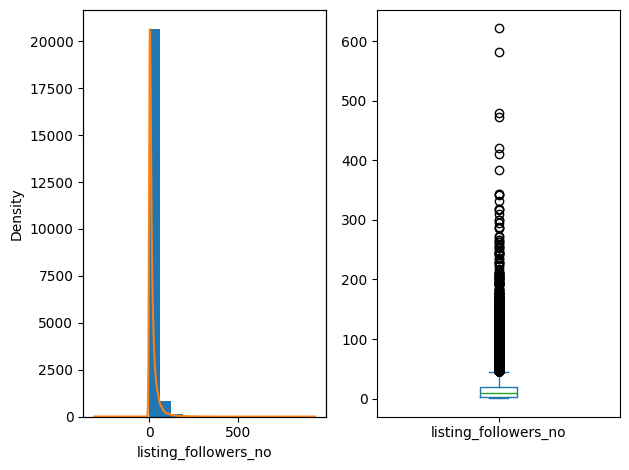

Descriptive statistics


count      21690.0
mean     17.466897
std       27.09941
min            1.0
25%            3.0
50%            9.0
75%           20.0
max          621.0
Name: listing_followers_no, dtype: Float64

Variance: 1.5514724534869182
Skewness: 5.4533789462300115
Kurtosis: 56.109096588422965

NA values
Count [n]: 2224
Percentage [%]: 9.299991636698168%

Univariate analysis of 'images_no' column
Histogram and box plot


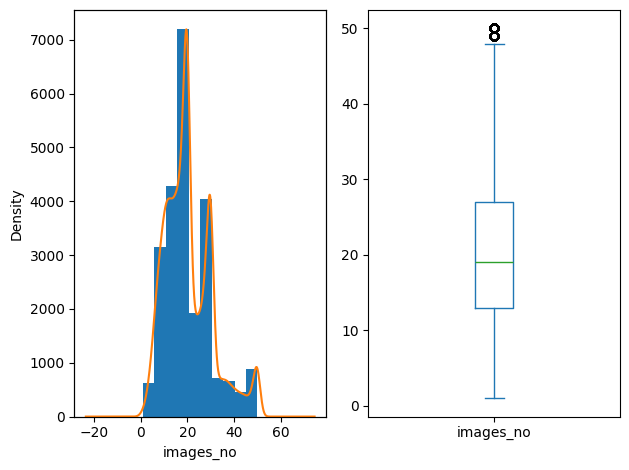

Descriptive statistics


count      23914.0
mean     20.516183
std      10.218567
min            1.0
25%           13.0
50%           19.0
75%           27.0
max           50.0
Name: images_no, dtype: Float64

Variance: 0.4980734989880374
Skewness: 0.8725663539850296
Kurtosis: 0.6413058855986296

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_kilometerage' column
Histogram and box plot


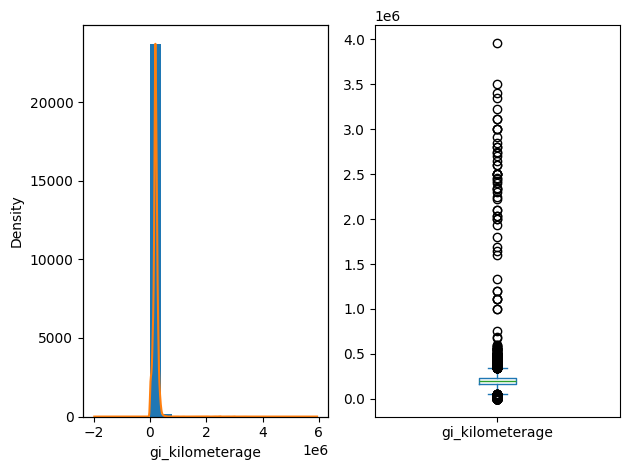

Descriptive statistics


count          23914.0
mean     199767.119637
std       128448.02545
min              500.0
25%          160469.25
50%           195012.5
75%           235000.0
max          3960000.0
Name: gi_kilometerage, dtype: Float64

Variance: 0.6429888246021186
Skewness: 13.485352053643203
Kurtosis: 276.29538574266616

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_production_year' column
Histogram and box plot


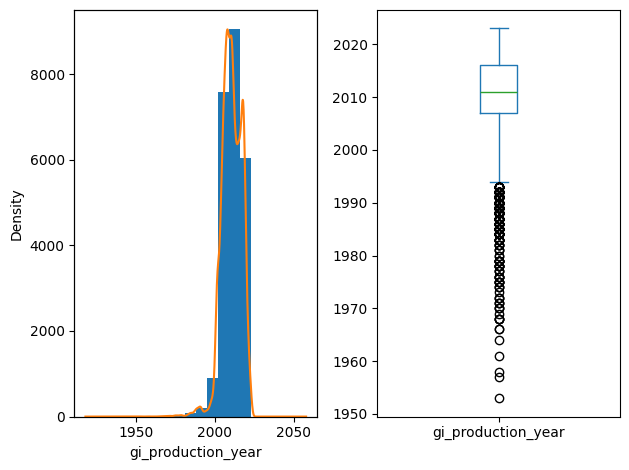

Descriptive statistics


count        23914.0
mean     2010.651083
std         6.287734
min           1953.0
25%           2007.0
50%           2011.0
75%           2016.0
max           2023.0
Name: gi_production_year, dtype: Float64

Variance: 0.003127212668854118
Skewness: -0.9139877518595897
Kurtosis: 3.5907908366990426

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_engine_capacity' column
Histogram and box plot


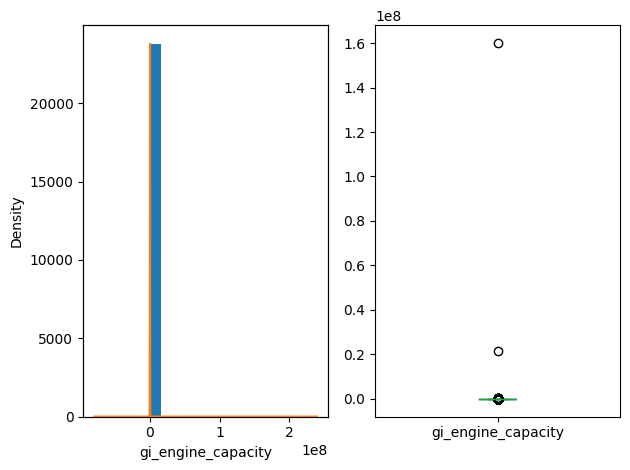

Descriptive statistics


count           23790.0
mean        9501.327196
std      1046973.955064
min               100.0
25%              1461.0
50%              1796.0
75%              1991.0
max         160051414.0
Name: gi_engine_capacity, dtype: Float64

Variance: 110.19239032957992
Skewness: 150.51305485060522
Kurtosis: 22957.12234065646

NA values
Count [n]: 124
Percentage [%]: 0.5185247135569122%

Univariate analysis of 'gi_engine_power' column
Histogram and box plot


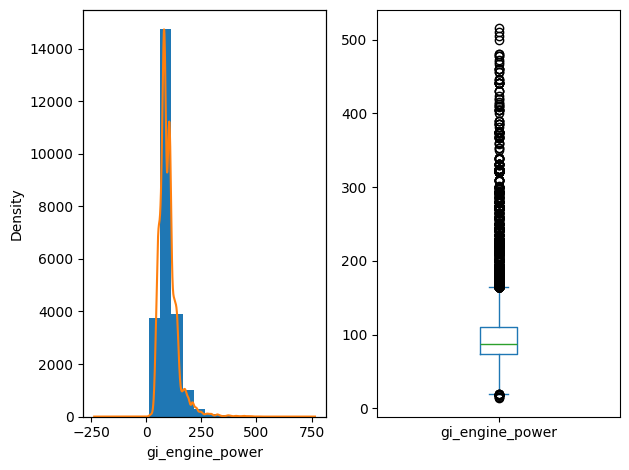

Descriptive statistics


count    23914.000000
mean        98.493268
std         43.259970
min         14.000000
25%         74.000000
50%         88.000000
75%        110.000000
max        515.000000
Name: gi_engine_power, dtype: float64

Variance: 0.43921752962820293
Skewness: 2.5991486561264177
Kurtosis: 12.815110415695802

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_battery_capacity' column
Histogram and box plot


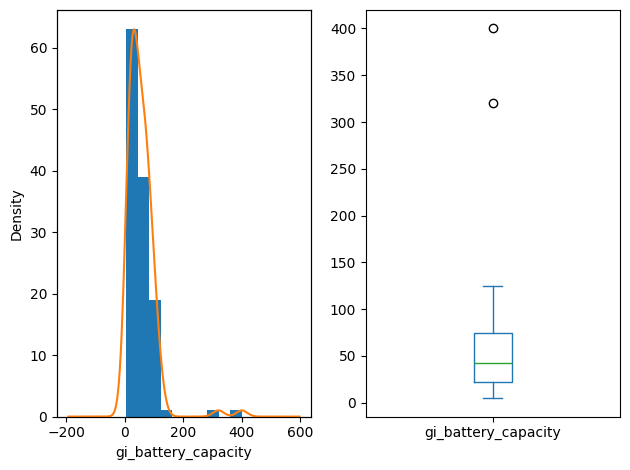

Descriptive statistics


count        124.0
mean     55.189194
std      49.326797
min            5.0
25%           22.0
50%           43.0
75%           75.0
max          400.0
Name: gi_battery_capacity, dtype: Float64

Variance: 0.893776365900111
Skewness: 4.049073419957126
Kurtosis: 23.644918127351094

NA values
Count [n]: 23790
Percentage [%]: 99.48147528644309%

Univariate analysis of 'ai_seats_no' column
Histogram and box plot


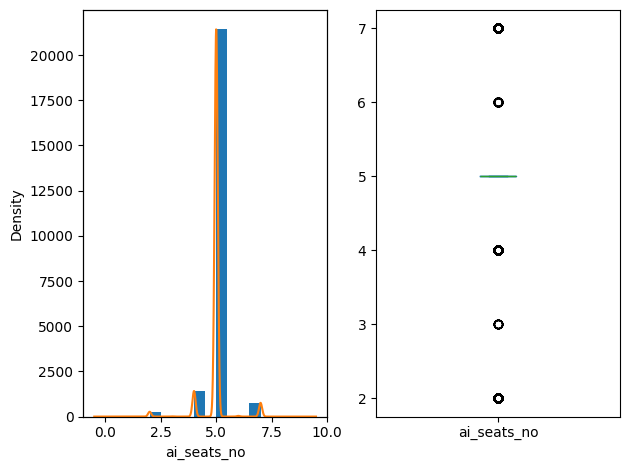

Descriptive statistics


count     23914.0
mean     4.971565
std      0.537891
min           2.0
25%           5.0
50%           5.0
75%           5.0
max           7.0
Name: ai_seats_no, dtype: Float64

Variance: 0.1081934544419987
Skewness: -0.5415286388477624
Kurtosis: 14.560947054112376

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'ai_deposit' column
Histogram and box plot


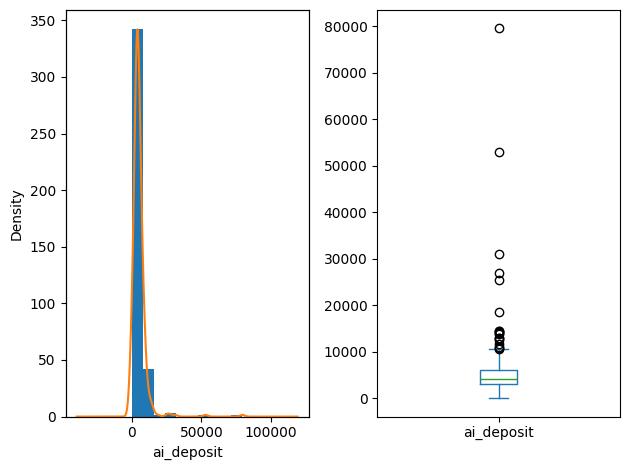

Descriptive statistics


count          390.0
mean     5072.266667
std      5689.389838
min              1.0
25%           3000.0
50%           4139.5
75%           6000.0
max          79480.0
Name: ai_deposit, dtype: Float64

Variance: 1.1216661527507992
Skewness: 7.868842607333459
Kurtosis: 87.76852788063391

NA values
Count [n]: 23524
Percentage [%]: 98.3691561428452%

Univariate analysis of 'ai_installment_no' column
Histogram and box plot


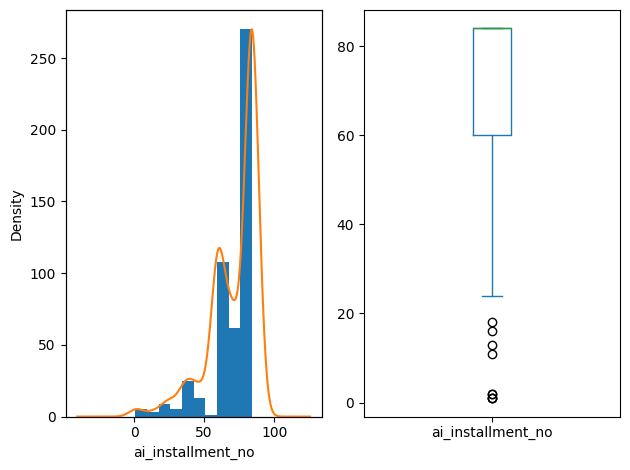

Descriptive statistics


count        501.0
mean     71.033932
std      17.602637
min            1.0
25%           60.0
50%           84.0
75%           84.0
max           84.0
Name: ai_installment_no, dtype: Float64

Variance: 0.24780604075148638
Skewness: -1.526945483512731
Kurtosis: 2.279085121354293

NA values
Count [n]: 23413
Percentage [%]: 97.90499289119344%

Univariate analysis of 'ai_installment_amount' column
Histogram and box plot


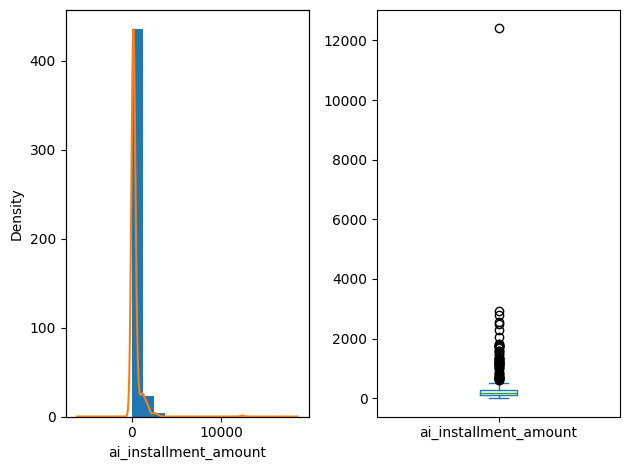

Descriptive statistics


count         463.0
mean     342.721382
std      705.902307
min             1.0
25%           115.0
50%           166.0
75%           283.0
max         12400.0
Name: ai_installment_amount, dtype: Float64

Variance: 2.0596973040451902
Skewness: 11.465464241782113
Kurtosis: 183.43053565651323

NA values
Count [n]: 23451
Percentage [%]: 98.06389562599314%

Univariate analysis of 'ai_cash_payment' column
Histogram and box plot


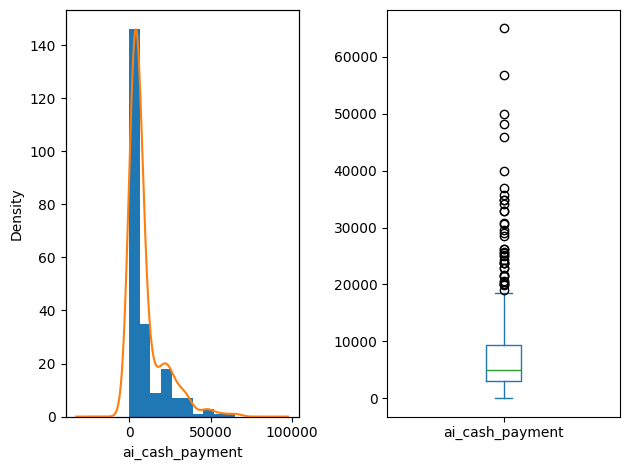

Descriptive statistics


count           228.0
mean      9369.486842
std      10902.129218
min               1.0
25%            3000.0
50%            4975.0
75%            9280.0
max           65000.0
Name: ai_cash_payment, dtype: Float64

Variance: 1.1635780487929837
Skewness: 2.2580116260567267
Kurtosis: 5.508153225476606

NA values
Count [n]: 23686
Percentage [%]: 99.04658359120181%

Univariate analysis of 'ai_range_on_full_battery_km' column
Histogram and box plot


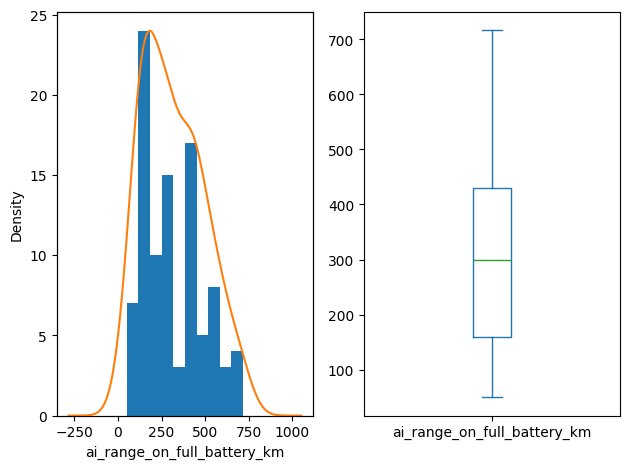

Descriptive statistics


count          96.0
mean     316.614583
std      173.835214
min            50.0
25%           160.0
50%           300.0
75%           430.0
max           717.0
Name: ai_range_on_full_battery_km, dtype: Float64

Variance: 0.5490436091664215
Skewness: 0.45528399442298184
Kurtosis: -0.7273385811541626

NA values
Count [n]: 23818
Percentage [%]: 99.59856151208497%

Cars with 'gi_kilometerage' = 0: 0
Removed cars with 'gi_kilometerage' = 0



,name,short_url,price,listing_followers_no,location,images_no,description,gi_brand,gi_model,gi_production_year,...,o_Garažiran,o_Kupljen_nov_u_Srbiji,o_Oldtimer,o_Prilagođeno_invalidima,o_Prvi_vlasnik,o_Restauriran,o_Rezervni_ključ,o_Servisna_knjiga,o_Test_vozilo,o_Tuning
id,,,,,,,,,,,,,,,,,,,,,
22503872,Mercedes Benz E 200 CDi Classic,https://www.polovniautomobili.com/auto-oglasi/...,4500,6,Čačak,20,Uslužna prodaja- Vozilo se nalazi kod nas Polo...,Mercedes Benz,E 200,2004,...,False,False,False,False,False,False,True,False,False,False
23210877,Opel Insignia EXCLUSIVE,https://www.polovniautomobili.com/auto-oglasi/...,15200,4,Leštane,30,Opel Insignija 1.6D 136 KS 6 brz. Auto je u na...,Opel,Insignia,2019,...,True,False,False,False,False,False,True,True,False,False


Replaced extreme value of 'gi_engine_capacity' with NaN (will be replaced with median)

Cars where 'gi_production_year' = 2024:  0

Listing names of cars where 'gi_engine_power' < 30 (horse power): <StringArray>
[               'Zastava 750',  'Zastava 750 presla 38.400',
 'Renault Twizy elektro  8kw',        'Volkswagen Buba 1.3',
           'Fiat 126 Peglica',                'Zastava 750',
      'Volkswagen Buba 1200J',                'Trabant 601',
            'Fiat 126 126PLG',             'Renault R 4 tl',
             'Renault R 4 tl',                'Opel Kadett',
     'Renault Twizy eletktro',                'Zastava 750',
             'Zastava 750 LE',                'Zastava 750',
          'Suzuki Maruti 800',   'Citroen Ami ami electric',
           'Fiat Cinquecento',                'Zastava 750',
     'Volkswagen Buba 1200 J',                'Zastava 750',
         'Zastava 750 750 le',                'Zastava 750',
                'Zastava 750',            'Zastava 750 7

In [11]:
df, metadata = ua_numerical_features(df=df, metadata=metadata)

### binary features

In [12]:
@preprocess_init
def ua_binary_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    display(Markdown("### Categories for every binary column"))
    for col in features_info["binary"]:
        display(nb_utils.get_value_counts_freq_with_perc(df, col))

    cols_scheduled_for_deletion = [
        "e_Fabrički_ugrađeno_dečije_sedište",
        "e_Volan_u_kombinaciji_drvo_ili_koža",
        "o_Oldtimer",
        "o_Prilagođeno_invalidima",
        "o_Restauriran",
        "o_Test_vozilo",
        "o_Tuning",
    ]
    print(f"Columns scheduled for deletion:\n{cols_scheduled_for_deletion}")
    print()

    const_false_strat_cols = ["ai_credit", "ai_interest_free_credit", "ai_leasing"]
    modus_strat_cols = [
        col
        for col in features_info["binary"]
        if col not in cols_scheduled_for_deletion + const_false_strat_cols
    ]
    print("NaN fill by False strategy columns:")
    print(const_false_strat_cols)
    print()

    cols_nan_strategy["const_false"].extend(const_false_strat_cols)
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("Extended 'const_false' and 'modus' cols_nan_strategy")

    features_info["features_to_delete"].extend(cols_scheduled_for_deletion)

    return df, metadata

In [13]:
df, metadata = ua_binary_features(df=df, metadata=metadata)

### Categories for every binary column

,count,percentage [%]
s_ABS,,
True,22191,92.795015
False,1723,7.204985


,count,percentage [%]
s_ASR,,
True,17322,72.434557
False,6592,27.565443


,count,percentage [%]
s_Airbag_za_suvozača,,
True,22362,93.510078
False,1552,6.489922


,count,percentage [%]
s_Airbag_za_vozača,,
True,22502,94.095509
False,1412,5.904491


,count,percentage [%]
s_Alarm,,
False,17385,72.698001
True,6529,27.301999


,count,percentage [%]
s_Asistencija_praćenja_trake,,
False,20480,85.640211
True,3434,14.359789


,count,percentage [%]
s_Automatsko_kočenje,,
False,20328,85.0046
True,3586,14.9954


,count,percentage [%]
s_Blokada_motora,,
False,17310,72.384377
True,6604,27.615623


,count,percentage [%]
s_Bočni_airbag,,
True,20731,86.689805
False,3183,13.310195


,count,percentage [%]
s_Centralno_zaključavanje,,
True,22007,92.025592
False,1907,7.974408


,count,percentage [%]
s_Child_lock,,
True,13355,55.845948
False,10559,44.154052


,count,percentage [%]
s_ESP,,
True,18299,76.52003
False,5615,23.47997


,count,percentage [%]
s_Kodiran_ključ,,
True,15144,63.326921
False,8770,36.673079


,count,percentage [%]
s_Mehanička_zaštita,,
False,22452,93.886426
True,1462,6.113574


,count,percentage [%]
s_OBD_zaštita,,
False,19298,80.697499
True,4616,19.302501


,count,percentage [%]
s_Senzor_mrtvog_ugla,,
False,21882,91.502885
True,2032,8.497115


,count,percentage [%]
s_Ulazak_bez_ključa,,
False,20133,84.189178
True,3781,15.810822


,count,percentage [%]
s_Vazdušni_jastuci_za_kolena,,
False,18879,78.945388
True,5035,21.054612


,count,percentage [%]
e_360_kamera,,
False,23008,96.211424
True,906,3.788576


,count,percentage [%]
e_AUX_konekcija,,
False,13737,57.443339
True,10177,42.556661


,count,percentage [%]
e_Adaptivna_svetla,,
False,19215,80.350422
True,4699,19.649578


,count,percentage [%]
e_Adaptivni_tempomat,,
False,20452,85.523125
True,3462,14.476875


,count,percentage [%]
e_Aluminijumske_felne,,
True,16967,70.950071
False,6947,29.049929


,count,percentage [%]
e_Ambijentalno_osvetljenje,,
False,20567,86.004014
True,3347,13.995986


,count,percentage [%]
e_Android_Auto,,
False,21476,89.805135
True,2438,10.194865


,count,percentage [%]
e_Apple_CarPlay,,
False,21535,90.051852
True,2379,9.948148


,count,percentage [%]
e_Asistencija_za_kretanje_na_uzbrdici,,
False,15248,63.761813
True,8666,36.238187


,count,percentage [%]
e_Automatsko_parkiranje,,
False,22186,92.774107
True,1728,7.225893


,count,percentage [%]
e_Automatsko_zatamnjivanje_retrovizora,,
False,17129,71.627499
True,6785,28.372501


,count,percentage [%]
e_Autonomna_vožnja,,
False,22995,96.157063
True,919,3.842937


,count,percentage [%]
e_Bluetooth,,
False,13145,54.967801
True,10769,45.032199


,count,percentage [%]
e_Branici_u_boji_auta,,
True,15433,64.535419
False,8481,35.464581


,count,percentage [%]
e_Brisači_prednjih_farova,,
False,21675,90.637284
True,2239,9.362716


,count,percentage [%]
e_CD_changer,,
False,20819,87.05779
True,3095,12.94221


,count,percentage [%]
e_DPF_filter,,
False,14062,58.802375
True,9852,41.197625


,count,percentage [%]
e_DVD_ili_TV,,
False,21546,90.097851
True,2368,9.902149


,count,percentage [%]
e_Daljinsko_zaključavanje,,
True,20237,84.62407
False,3677,15.37593


,count,percentage [%]
e_Digitalni_radio,,
False,18633,77.916702
True,5281,22.083298


,count,percentage [%]
e_Dnevna_svetla,,
True,12530,52.396086
False,11384,47.603914


,count,percentage [%]
e_Držači_za_čaše,,
True,18451,77.155641
False,5463,22.844359


,count,percentage [%]
e_Ekran_na_dodir,,
False,17868,74.717739
True,6046,25.282261


,count,percentage [%]
e_Električni_podizači,,
True,21850,91.369073
False,2064,8.630927


,count,percentage [%]
e_Električni_retrovizori,,
True,20376,85.205319
False,3538,14.794681


,count,percentage [%]
e_Elektro_otvaranje_prtljažnika,,
False,13786,57.64824
True,10128,42.35176


,count,percentage [%]
e_Elektro_podesiva_sedišta,,
False,18478,77.268546
True,5436,22.731454


,count,percentage [%]
e_Elektro_sklopivi_retrovizori,,
False,17146,71.698587
True,6768,28.301413


,count,percentage [%]
e_Elektro_zatvaranje_prtljažnika,,
False,21796,91.143263
True,2118,8.856737


,count,percentage [%]
e_Elektronska_ručna_kočnica,,
False,16635,69.561763
True,7279,30.438237


,count,percentage [%]
e_Fabrički_ugrađeno_dečije_sedište,,
False,23821,99.611106
True,93,0.388894


,count,percentage [%]
e_Glasovne_komande,,
False,19567,81.822363
True,4347,18.177637


,count,percentage [%]
e_Grejanje_sedišta,,
False,17570,73.471607
True,6344,26.528393


,count,percentage [%]
e_Grejanje_volana,,
False,23110,96.637953
True,804,3.362047


,count,percentage [%]
e_Grejači_retrovizora,,
True,17841,74.604834
False,6073,25.395166


,count,percentage [%]
e_Grejači_vetrobranskog_stakla,,
False,19248,80.488417
True,4666,19.511583


,count,percentage [%]
e_Hands_free,,
False,16618,69.490675
True,7296,30.509325


,count,percentage [%]
e_Hard_disk,,
False,22251,93.045915
True,1663,6.954085


,count,percentage [%]
e_Head_up_display,,
False,23009,96.215606
True,905,3.784394


,count,percentage [%]
e_ISOFIX_sistem,,
True,17232,72.058209
False,6682,27.941791


,count,percentage [%]
e_Indikator_niskog_pritiska_u_gumama,,
False,14187,59.325082
True,9727,40.674918


,count,percentage [%]
e_Kamera,,
False,20047,83.829556
True,3867,16.170444


,count,percentage [%]
e_Keramičke_kočnice,,
False,23704,99.121853
True,210,0.878147


,count,percentage [%]
e_Kožni_volan,,
True,15413,64.451786
False,8501,35.548214


,count,percentage [%]
e_Krovni_nosač,,
False,17753,74.236849
True,6161,25.763151


,count,percentage [%]
e_Kuka_za_vuču,,
False,21279,88.98135
True,2635,11.01865


,count,percentage [%]
e_LED_prednja_svetla,,
False,15939,66.651334
True,7975,33.348666


,count,percentage [%]
e_LED_zadnja_svetla,,
False,16020,66.990048
True,7894,33.009952


,count,percentage [%]
e_MP3,,
False,13251,55.411056
True,10663,44.588944


,count,percentage [%]
e_Masažna_sedišta,,
False,23282,97.357197
True,632,2.642803


,count,percentage [%]
e_Matrix_farovi,,
False,22673,94.810571
True,1241,5.189429


,count,percentage [%]
e_Memorija_sedišta,,
False,22275,93.146274
True,1639,6.853726


,count,percentage [%]
e_Metalik_boja,,
True,13878,58.032951
False,10036,41.967049


,count,percentage [%]
e_Modovi_vožnje,,
False,19634,82.102534
True,4280,17.897466


,count,percentage [%]
e_Multifunkcionalni_volan,,
True,15417,64.468512
False,8497,35.531488


,count,percentage [%]
e_Multimedija,,
False,14522,60.725935
True,9392,39.274065


,count,percentage [%]
e_Naslon_za_ruku,,
True,15378,64.305428
False,8536,35.694572


,count,percentage [%]
e_Navigacija,,
False,15269,63.849628
True,8645,36.150372


,count,percentage [%]
e_Ostava_sa_hlađenjem,,
False,15955,66.71824
True,7959,33.28176


,count,percentage [%]
e_Otvor_za_skije,,
False,20676,86.459814
True,3238,13.540186


,count,percentage [%]
e_Paljenje_bez_ključa,,
False,18803,78.627582
True,5111,21.372418


,count,percentage [%]
e_Panorama_krov,,
False,21887,91.523794
True,2027,8.476206


,count,percentage [%]
e_Parking_senzori,,
False,12854,53.750941
True,11060,46.249059


,count,percentage [%]
e_Podešavanje_volana_po_visini,,
True,19300,80.705863
False,4614,19.294137


,count,percentage [%]
e_Postolje_za_bežično_punjenje_telefona,,
False,22974,96.069248
True,940,3.930752


,count,percentage [%]
e_Prednja_noćna_kamera,,
False,23544,98.452789
True,370,1.547211


,count,percentage [%]
e_Privlačenje_vrata_pri_zatvaranju,,
False,23441,98.022079
True,473,1.977921


,count,percentage [%]
e_Putni_računar,,
True,18687,78.142511
False,5227,21.857489


,count,percentage [%]
e_Radio_CD,,
True,16899,70.665719
False,7015,29.334281


,count,percentage [%]
e_Radio_ili_Kasetofon,,
True,13680,57.204985
False,10234,42.795015


,count,percentage [%]
e_Retrovizor_se_obara_pri_rikvercu,,
False,21096,88.216108
True,2818,11.783892


,count,percentage [%]
e_Rezervni_točak,,
False,12502,52.279
True,11412,47.721


,count,percentage [%]
e_Ručice_za_menjanje_brzina_na_volanu,,
False,21159,88.479552
True,2755,11.520448


,count,percentage [%]
e_Sedišta_podesiva_po_visini,,
True,16528,69.114326
False,7386,30.885674


,count,percentage [%]
e_Senzori_za_kišu,,
True,12575,52.58426
False,11339,47.41574


,count,percentage [%]
e_Senzori_za_svetla,,
True,12010,50.221627
False,11904,49.778373


,count,percentage [%]
e_Servo_volan,,
True,22408,93.702434
False,1506,6.297566


,count,percentage [%]
e_Sportska_sedišta,,
False,19305,80.726771
True,4609,19.273229


,count,percentage [%]
e_Sportsko_vešanje,,
False,21758,90.984361
True,2156,9.015639


,count,percentage [%]
e_Start_stop_sistem,,
False,17519,73.258342
True,6395,26.741658


,count,percentage [%]
e_Subwoofer,,
False,22297,93.23827
True,1617,6.76173


,count,percentage [%]
e_Svetla_za_maglu,,
True,17527,73.291796
False,6387,26.708204


,count,percentage [%]
e_Tempomat,,
True,14816,61.95534
False,9098,38.04466


,count,percentage [%]
e_Tonirana_stakla,,
True,18661,78.033788
False,5253,21.966212


,count,percentage [%]
e_Torba_za_skije,,
False,23549,98.473697
True,365,1.526303


,count,percentage [%]
e_USB,,
False,14150,59.17036
True,9764,40.82964


,count,percentage [%]
e_Upravljanje_na_sva_četiri_točka,,
False,23052,96.395417
True,862,3.604583


,count,percentage [%]
e_Utičnica_od_12V,,
True,16542,69.172869
False,7372,30.827131


,count,percentage [%]
e_Vazdušno_vešanje,,
False,23112,96.646316
True,802,3.353684


,count,percentage [%]
e_Ventilacija_sedišta,,
False,23415,97.913356
True,499,2.086644


,count,percentage [%]
e_Virtuelna_tabla,,
False,22306,93.275905
True,1608,6.724095


,count,percentage [%]
e_Volan_u_kombinaciji_drvo_ili_koža,,
False,23774,99.414569
True,140,0.585431


,count,percentage [%]
e_Webasto,,
False,23112,96.646316
True,802,3.353684


,count,percentage [%]
e_Xenon_svetla,,
False,18243,76.285858
True,5671,23.714142


,count,percentage [%]
e_Zaključavanje_diferencijala,,
False,23161,96.851217
True,753,3.148783


,count,percentage [%]
e_Zavesice_na_zadnjim_prozorima,,
False,22943,95.939617
True,971,4.060383


,count,percentage [%]
e_Šiber,,
False,22372,93.551894
True,1542,6.448106


,count,percentage [%]
o_Garancija,,
False,17762,74.274484
True,6152,25.725516


,count,percentage [%]
o_Garažiran,,
False,14437,60.370494
True,9477,39.629506


,count,percentage [%]
o_Kupljen_nov_u_Srbiji,,
False,21770,91.03454
True,2144,8.96546


,count,percentage [%]
o_Oldtimer,,
False,23845,99.711466
True,69,0.288534


,count,percentage [%]
o_Prilagođeno_invalidima,,
False,23907,99.970728
True,7,0.029272


,count,percentage [%]
o_Prvi_vlasnik,,
False,19390,81.082211
True,4524,18.917789


,count,percentage [%]
o_Restauriran,,
False,23866,99.799281
True,48,0.200719


,count,percentage [%]
o_Rezervni_ključ,,
True,11958,50.004182
False,11956,49.995818


,count,percentage [%]
o_Servisna_knjiga,,
False,13376,55.933763
True,10538,44.066237


,count,percentage [%]
o_Test_vozilo,,
False,23851,99.736556
True,63,0.263444


,count,percentage [%]
o_Tuning,,
False,23786,99.464749
True,128,0.535251


,count,percentage [%]
ai_doors_no,,
True,21451,89.700594
False,2462,10.295225
<NA>,1,0.004182


,count,percentage [%]
ai_credit,,
<NA>,22469,93.957514
True,1445,6.042486


,count,percentage [%]
ai_interest_free_credit,,
<NA>,23757,99.343481
True,157,0.656519


,count,percentage [%]
ai_leasing,,
<NA>,23302,97.44083
True,612,2.55917


Columns scheduled for deletion:
['e_Fabrički_ugrađeno_dečije_sedište', 'e_Volan_u_kombinaciji_drvo_ili_koža', 'o_Oldtimer', 'o_Prilagođeno_invalidima', 'o_Restauriran', 'o_Test_vozilo', 'o_Tuning']

NaN fill by False strategy columns:
['ai_credit', 'ai_interest_free_credit', 'ai_leasing']

Extended 'const_false' and 'modus' cols_nan_strategy


### other features

In [14]:
@preprocess_init
def ua_other_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    # Subset of other columns
    other_columns = ["gi_certified", "ai_registered_until"]

    display(Markdown("### Descriptive statistics of other columns"))
    display(df[other_columns].describe())
    print("Missing values of other columns")
    nb_utils.get_nas(df[other_columns])  # type: ignore

    today_date = np.datetime64("2024-01")

    df.gi_certified = pd.to_numeric(
        (df.gi_certified - today_date).dt.days.astype("Int64"),  # type: ignore
        downcast="signed",
    )
    df.ai_registered_until = pd.to_numeric(
        (df.ai_registered_until - today_date).dt.days.astype("Int64"),  # type: ignore
        downcast="signed",
    )
    print(
        "Transformed 'gi_certified' and 'ai_registered_until' to difference of '2024-01' date and corresponding dates"
    )
    print()

    display(Markdown("### Univariate analysis of transformed other columns"))
    for col in other_columns:
        nb_utils.show_hist_box_numerical_col(df, col)
    print()

    cols_nan_strategy["const_0"].extend(other_columns)
    print("NaN constant 0 strategy columns:")
    print(other_columns)

    for col in other_columns:
        features_info["other"].remove(col)
    print(f"Removed {other_columns} from other features")

    features_info["numerical"].extend(other_columns)
    print(f"Added {other_columns} to numerical features")

    return df, metadata

### Descriptive statistics of other columns

,gi_certified,ai_registered_until
count,1186,13550
mean,2027-01-01 03:37:20.134907392,2024-07-09 00:45:54.597786112
min,2022-05-01 00:00:00,2021-06-01 00:00:00
25%,2025-10-01 00:00:00,2024-04-01 00:00:00
50%,2027-03-01 00:00:00,2024-07-01 00:00:00
75%,2028-01-01 00:00:00,2024-10-01 00:00:00
max,2033-12-01 00:00:00,2025-03-01 00:00:00


Missing values of other columns
Transformed 'gi_certified' and 'ai_registered_until' to difference of '2024-01' date and corresponding dates



### Univariate analysis of transformed other columns

Univariate analysis of 'gi_certified' column
Histogram and box plot


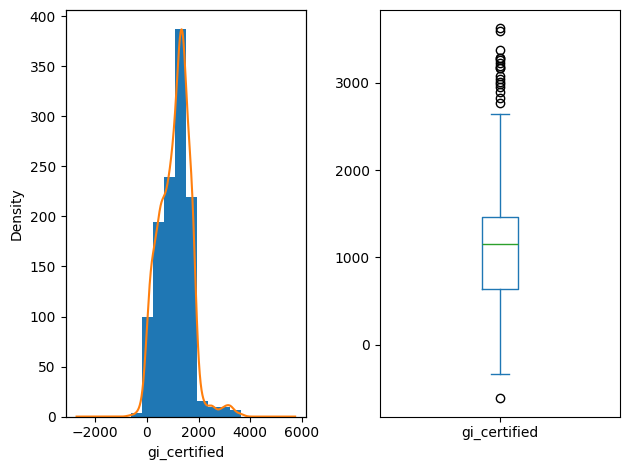

Descriptive statistics


count         1186.0
mean     1096.150927
std       591.904752
min           -610.0
25%            639.0
50%           1155.0
75%           1461.0
max           3622.0
Name: gi_certified, dtype: Float64

Variance: 0.5399847203046976
Skewness: 0.3635195545009763
Kurtosis: 1.0764350966037028

NA values
Count [n]: 22728
Percentage [%]: 95.04056201388308%
Univariate analysis of 'ai_registered_until' column
Histogram and box plot


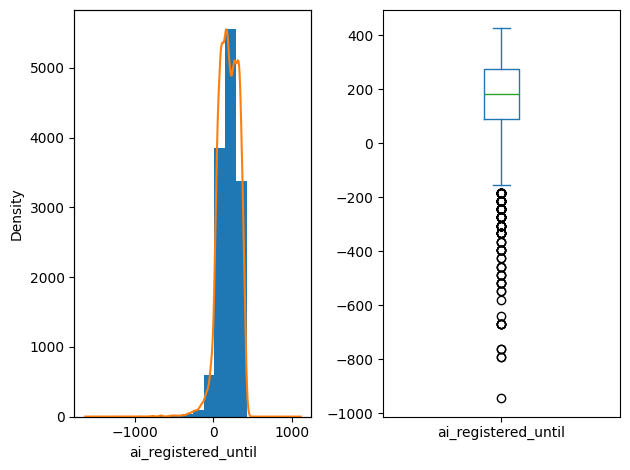

Descriptive statistics


count       13550.0
mean     190.031882
std       125.82442
min          -944.0
25%            91.0
50%           182.0
75%           274.0
max           425.0
Name: ai_registered_until, dtype: Float64

Variance: 0.6621226851929353
Skewness: -0.8992075997850022
Kurtosis: 3.361841336737604

NA values
Count [n]: 10364
Percentage [%]: 43.33863009115999%

NaN constant 0 strategy columns:
['gi_certified', 'ai_registered_until']
Removed ['gi_certified', 'ai_registered_until'] from other features
Added ['gi_certified', 'ai_registered_until'] to numerical features


In [15]:
df, metadata = ua_other_features(df=df, metadata=metadata)

## Testing

### Test individual components

In [16]:
def get_func_from_globals(func: Callable) -> Callable:
    result_func_name: str = func.__name__
    result_func: Callable = globals()[result_func_name]

    if not callable(result_func):
        raise Exception(
            f"Provided function {func.__name__} is not a function in globals."
        )
    return result_func


class TestNotebook(nb_utils.TestNotebookGeneric):
    # Testing only df_train
    def test_single_funcs(self):
        transf_obj: UACleaner = self.transformer_obj  # type: ignore

        df_prep, metadata_prep = nb_utils.load_artifacts(PREVIOUS_STAGE)
        # Get df_train
        df_prep, _ = train_test_split_nb(df)

        all_funcs_to_test: list[Callable] = [
            transf_obj.ua_nominal_features,
            transf_obj.ua_ordinal_features,
            transf_obj.ua_numerical_features,
            transf_obj.ua_binary_features,
        ]

        for func_to_test in all_funcs_to_test:
            print(f"{func_to_test.__name__=}")
            self._test_single_func(
                func_to_test,
                get_func_from_globals(func_to_test),
                df=df_prep,
                metadata=metadata_prep,
            )

    def test_whole_component(self, df_nb: Dataset, metadata_nb: Metadata):
        df_init_py, metadata_init_py = nb_utils.load_artifacts(PREVIOUS_STAGE)
        df_init_py, _ = train_test_split_nb(df_init_py)
        self._test_whole_component_complex(
            df_init_py, metadata_init_py, df_nb, metadata_nb
        )

In [ ]:
test_obj = TestNotebook(UACleaner())
test_obj.test_single_funcs()

### Test whole component

In [18]:
test_obj.test_whole_component(df_nb=df, metadata_nb=metadata)

## Save cleaned data and metadata in artifacts

In [19]:
nb_utils.save_artifacts(STAGE, df, metadata)